In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from geopy.distance import geodesic 

from IPython.display import display

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

%matplotlib inline

## Import and preparing data

In [2]:
path = '../data/'

In [3]:
distance = pd.read_csv(path + "flight_data_de_with_distances_v2.csv")
routes = pd.read_csv(path + "flight_data_de.csv")

In [4]:
# drop uncomfortable column
distance = distance.drop(columns=["Unnamed: 0"])

In [5]:
distance.dtypes

flight       object
distance    float64
dtype: object

In [6]:
routes.dtypes

route           object
fr_country      object
fr_airport      object
to_country      object
to_airport      object
month           object
flight_d       float64
seat_d         float64
passenger_d    float64
dtype: object

In [7]:
# correct the type of "month"
routes["month"] = pd.to_datetime(routes["month"])

In [8]:
routes.dtypes

route                  object
fr_country             object
fr_airport             object
to_country             object
to_airport             object
month          datetime64[ns]
flight_d              float64
seat_d                float64
passenger_d           float64
dtype: object

### Subset Berlin flights

- Berlin Schönefeld Airport (IATA: SXF, ICAO: EDDB)
- Berlin Tegel "Otto Lilienthal" Airport (IATA: TXL, ICAO: EDDT)

In [9]:
routes_b = routes.loc[(routes["fr_airport"] == "EDDB")|(routes["fr_airport"] == "EDDT")]

In [10]:
len(routes_b)/len(routes)

0.09414884697318816

Berlin represent almost 10% routes of Germany (but double check: German routes over-represented)

-- actually is not the right calculation, since every domestic flight for the Germany dataset would be double, If there is time, make the correct calculation. Speculative, it will be somewhere around 15% 

In [11]:
# there are not information about flights_d before January 2003. Subset the dataframe to be consistent with the info
routes_b = routes_b[(routes_b["month"] > "2002-12-01")]


In [12]:
# take a look at the dataset 
routes_b

,route,fr_country,fr_airport,to_country,to_airport,month,flight_d,seat_d,passenger_d
0,DE_EDDB_BE_EBBR,DE,EDDB,BE,EBBR,2019-11-01,47.0,8166.0,7306.0
1,DE_EDDB_BG_LBSF,DE,EDDB,BG,LBSF,2019-11-01,26.0,4914.0,4406.0
2,DE_EDDB_CH_LSGG,DE,EDDB,CH,LSGG,2019-11-01,50.0,7896.0,6586.0
3,DE_EDDB_CH_LSZM,DE,EDDB,CH,LSZM,2019-11-01,45.0,7372.0,6341.0
4,DE_EDDB_DE_EDDK,DE,EDDB,DE,EDDK,2019-11-01,8.0,64.0,14.0
...,...,...,...,...,...,...,...,...,...
154511,DE_EDDT_NL_EHAM,DE,EDDT,NL,EHAM,2003-01-01,140.0,13578.0,9261.0
154512,DE_EDDT_TR_LTAI,DE,EDDT,TR,LTAI,2003-01-01,28.0,5184.0,3405.0
154513,DE_EDDT_TR_LTBA,DE,EDDT,TR,LTBA,2003-01-01,55.0,8755.0,5548.0
154514,DE_EDDT_UK_EGLL,DE,EDDT,UK,EGLL,2003-01-01,151.0,20073.0,13915.0


In [13]:
# take a look at the stats at the moment
routes_b.describe()

,flight_d,seat_d,passenger_d
count,14754.000000,14754.000000,14754.000000
mean,102.141318,15795.207876,11892.887963
std,123.669766,19320.757574,14266.350248
min,1.000000,6.000000,1.000000
25%,31.000000,5425.000000,4317.500000
50%,58.000000,9199.500000,7091.000000
75%,106.000000,16105.500000,12244.250000
max,824.000000,148625.000000,113748.000000


## Monthly Data

check if seasonality

In [14]:
monthly_b = routes_b.groupby("month").sum()[["flight_d","passenger_d", "seat_d"]]
monthly_b

,flight_d,passenger_d,seat_d
month,,,
2003-01-01,4593.0,371673.0,601285.0
2003-02-01,4351.0,376912.0,575136.0
2003-03-01,4766.0,413357.0,634643.0
2003-04-01,4568.0,407276.0,608074.0
2003-05-01,4917.0,448889.0,663962.0
...,...,...,...
2019-07-01,9663.0,1371637.0,1631624.0
2019-08-01,9355.0,1285073.0,1572916.0
2019-09-01,9846.0,1385221.0,1670736.0


BER 3.748 million (DE 82.79 million)=> 4,5% of the population

from Sep to Nov 2019 departured from Berliner Airports the equivalent to the whole Berlin population

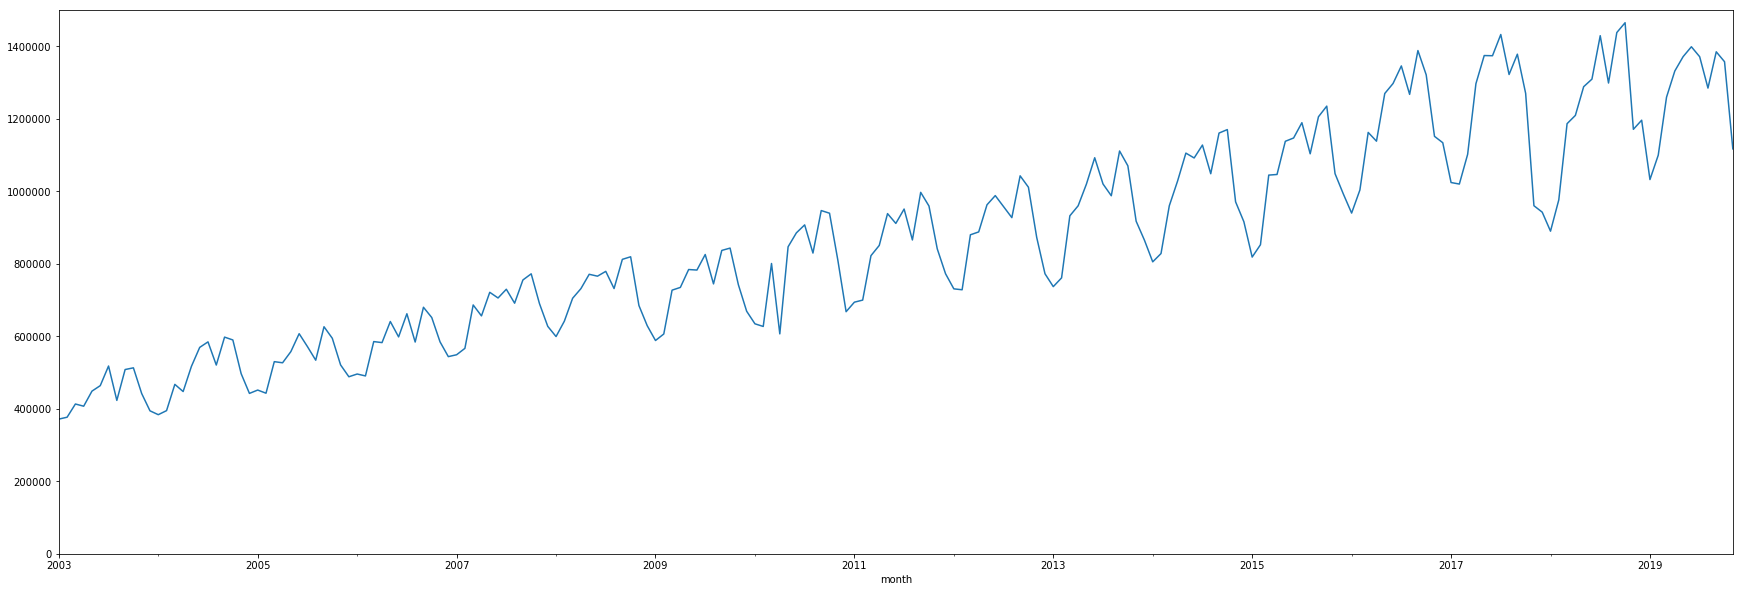

In [15]:
# based on the amount of passangers
fig, ax = plt.subplots(figsize=(30,10));
monthly_b["passenger_d"].plot(ax=ax);
plt.ylim(0,1500000);

Strong seasonality in Berlin

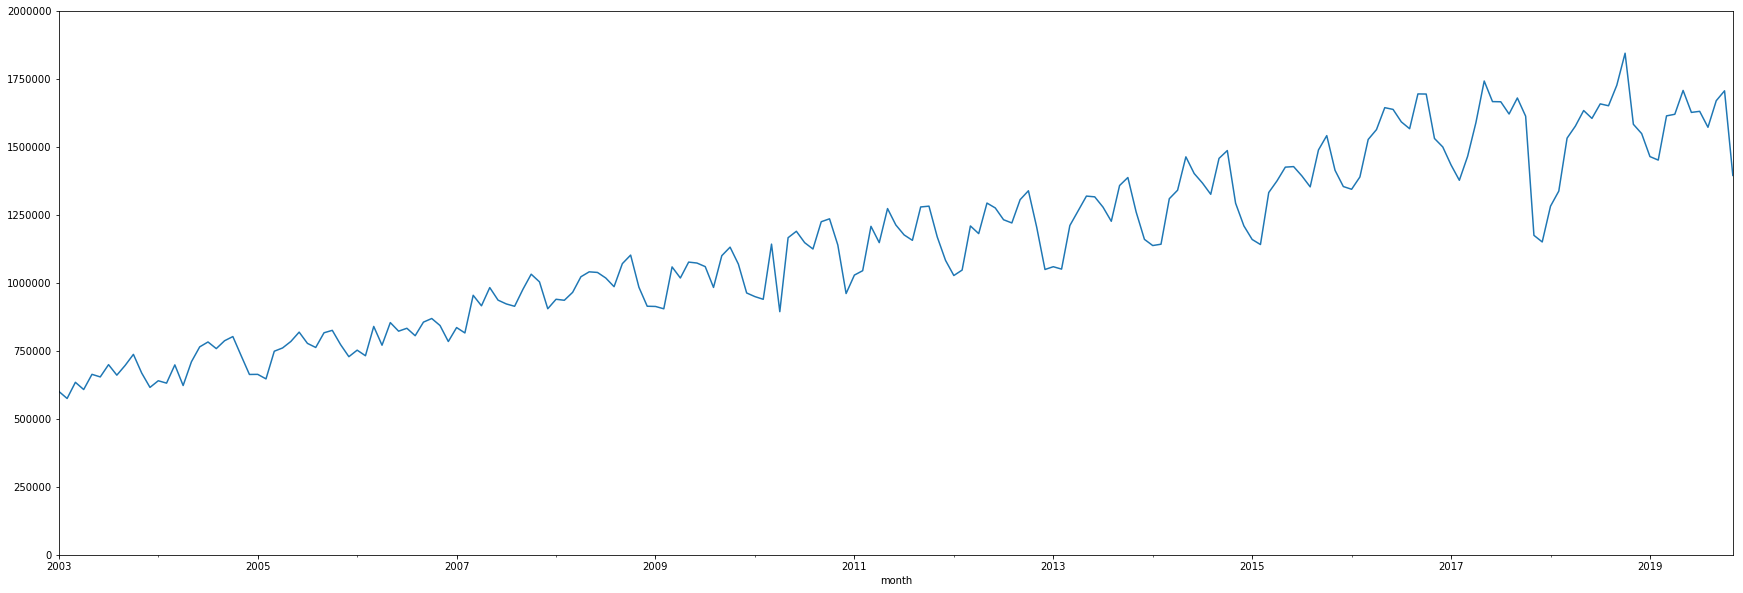

In [16]:
fig, ax = plt.subplots(figsize=(30,10));
monthly_b["seat_d"].plot(ax=ax);
plt.ylim(0,2000000);

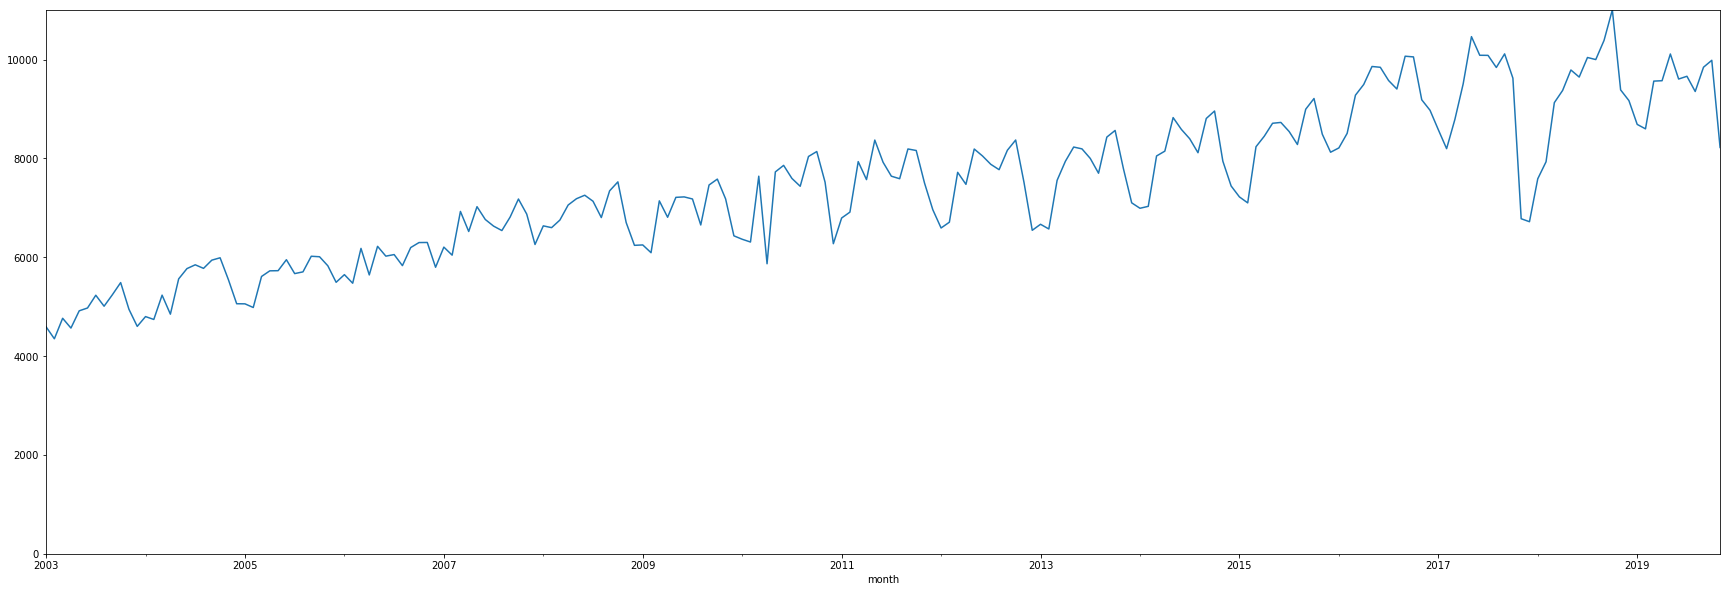

In [17]:
fig, ax = plt.subplots(figsize=(30,10));
monthly_b["flight_d"].plot(ax=ax);
plt.ylim(0,11000);

### Strong seasonality in Berlin
check with one parameter for different airports

In [18]:
# group by month, keeping fr_airport
monthly_b_2 = (routes_b.groupby(["month","fr_airport"])
                       .sum()[["flight_d","passenger_d", "seat_d"]]
                       .reset_index()
                       .set_index("month"))

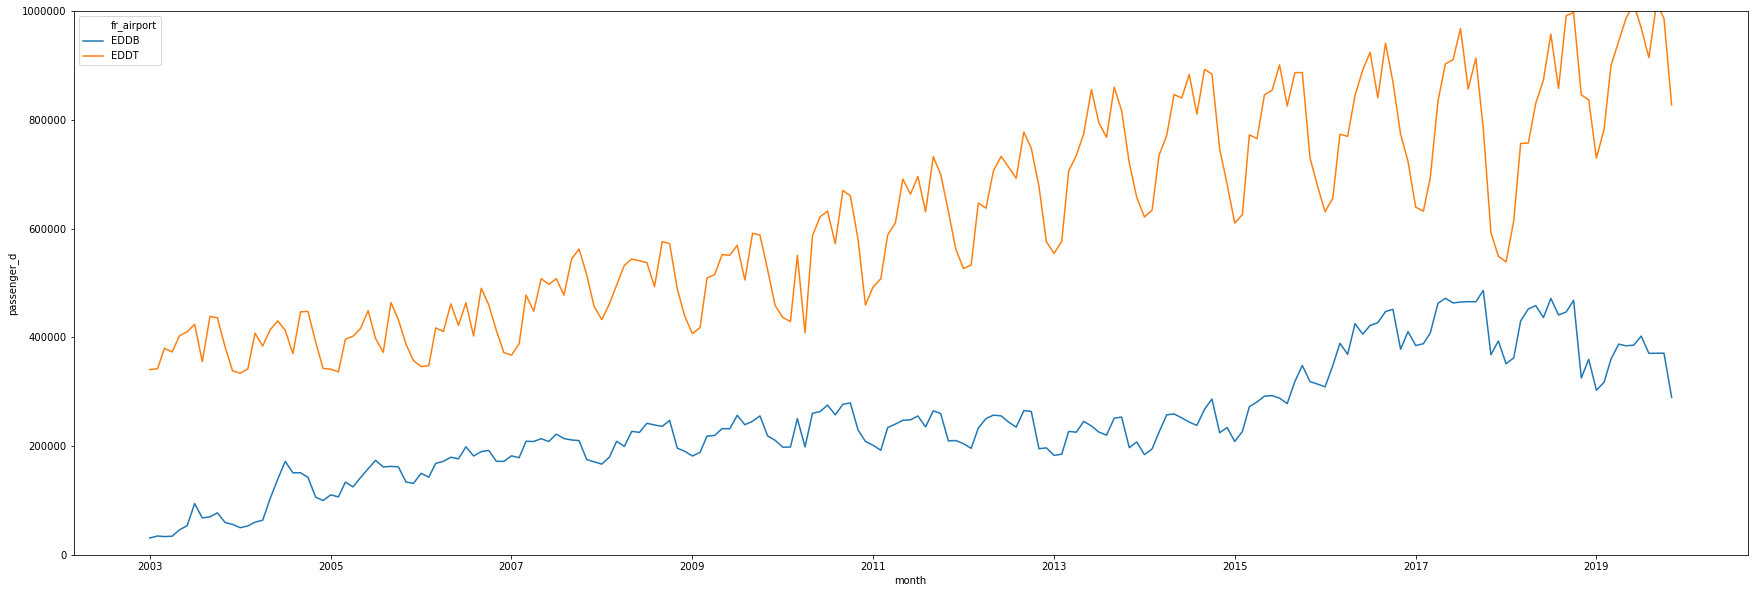

In [19]:
# Berlin Schönefeld Airport (IATA: SXF, ICAO: EDDB)
# Berlin Tegel "Otto Lilienthal" Airport (IATA: TXL, ICAO: EDDT)
fig, ax = plt.subplots(figsize=(30,10));
sns.lineplot(data=monthly_b_2, x=monthly_b_2.index, y="passenger_d", hue="fr_airport");
plt.ylim(0,1000000);

In [20]:
routes_b_2018 = routes_b[(routes_b["month"] > "2017-12-01") & (routes_b["month"] < "2019-01-01")]
routes_b_2018

,route,fr_country,fr_airport,to_country,to_airport,month,flight_d,seat_d,passenger_d
9742,DE_EDDB_AT_LOWW,DE,EDDB,AT,LOWW,2018-12-01,33.0,4512.0,2904.0
9743,DE_EDDB_BE_EBBR,DE,EDDB,BE,EBBR,2018-12-01,39.0,7371.0,6790.0
9744,DE_EDDB_BG_LBSF,DE,EDDB,BG,LBSF,2018-12-01,34.0,6060.0,5701.0
9745,DE_EDDB_CH_LSGG,DE,EDDB,CH,LSGG,2018-12-01,62.0,9557.0,7980.0
9746,DE_EDDB_CH_LSZH,DE,EDDB,CH,LSZH,2018-12-01,5.0,54.0,14.0
...,...,...,...,...,...,...,...,...,...
20477,DE_EDDT_UA_UKBB,DE,EDDT,UA,UKBB,2018-01-01,32.0,5874.0,2565.0
20478,DE_EDDT_UK_EGLC,DE,EDDT,UK,EGLC,2018-01-01,64.0,5942.0,4128.0
20479,DE_EDDT_UK_EGLL,DE,EDDT,UK,EGLL,2018-01-01,274.0,42576.0,27121.0
20480,DE_EDDT_US_KEWR,DE,EDDT,US,KEWR,2018-01-01,18.0,3821.0,2810.0


In [21]:
monthly_b_2018 = (routes_b_2018.groupby(["month","fr_airport"])
                  .sum()[["flight_d","passenger_d", "seat_d"]]
                  .reset_index()
                  .set_index("month"))

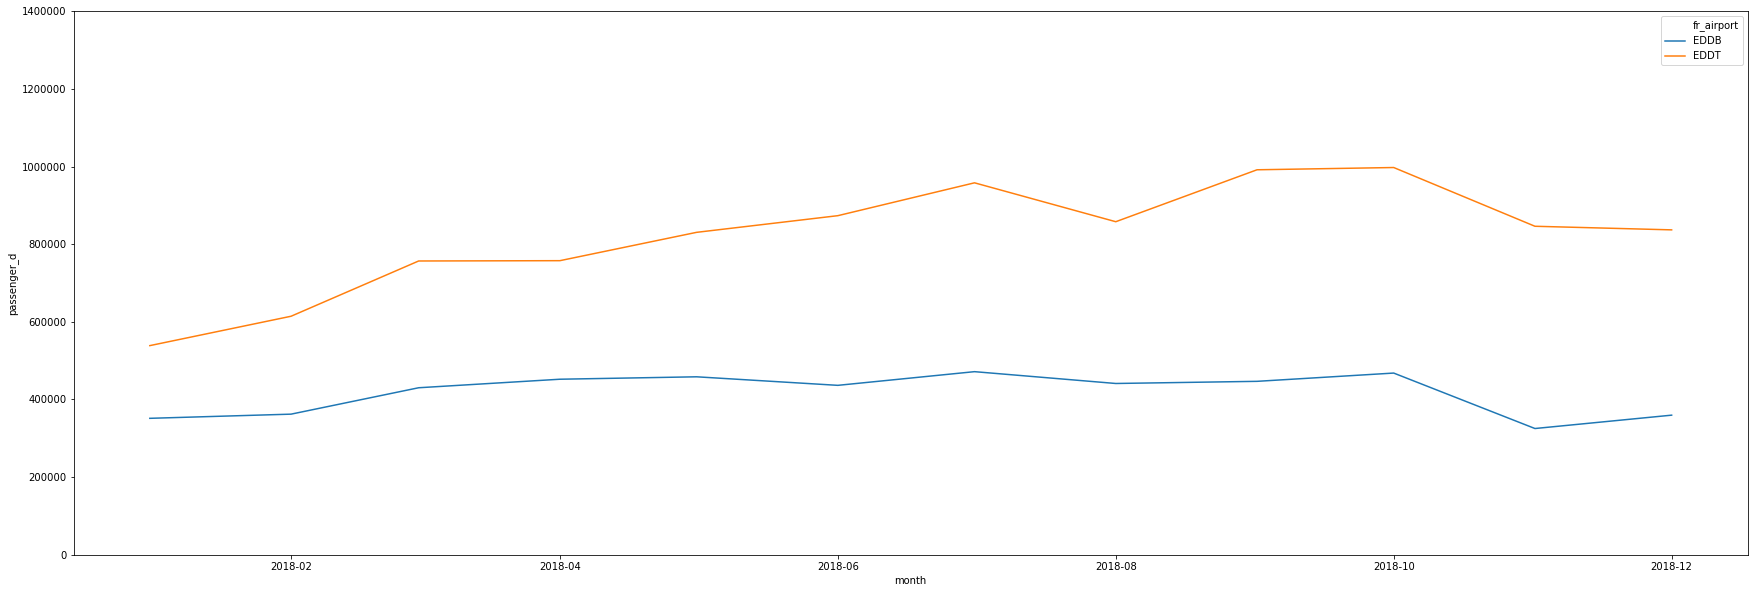

In [22]:
fig, ax = plt.subplots(figsize=(30,10));
sns.lineplot(data=monthly_b_2018, x=monthly_b_2018.index, y="passenger_d", hue="fr_airport");
plt.ylim(0,1400000);

#### it seems TXL has stronger effect the seasonality
However if we focus in one single year, the seasonality is not so obvious

Strange visual effect :/
#### find the right graph to show and tell!!!

## Flights from Berlin by country of destination (in the year 2018)

In [23]:
routes_b_2018_country = (routes_b_2018
                         .groupby(["to_country"])
                         .sum()[["flight_d","passenger_d", "seat_d"]]
                         .reset_index()
                         .sort_values(by="flight_d", ascending=False)
                         .reset_index(drop=True))

In [24]:
# add some stats "utilisation" & avg_plane
routes_b_2018_country = (routes_b_2018_country
                         .assign(utilisation = routes_b_2018_country['passenger_d'] / routes_b_2018_country['seat_d']))
routes_b_2018_country = (routes_b_2018_country
                         .assign(avg_plane = (routes_b_2018_country['seat_d'] / routes_b_2018_country['flight_d'])))


In [25]:
routes_b_2018_country

,to_country,flight_d,passenger_d,seat_d,utilisation,avg_plane
0,DE,35716.0,4173153.0,5800493.0,0.719448,162.406009
1,UK,9757.0,1313665.0,1569003.0,0.837261,160.807933
2,ES,9350.0,1403958.0,1639188.0,0.856496,175.314225
3,CH,7776.0,920483.0,1213409.0,0.758593,156.045396
4,IT,6287.0,959874.0,1109913.0,0.864819,176.540958
5,FR,5031.0,741827.0,895939.0,0.827988,178.083681
6,AT,4857.0,520277.0,757185.0,0.687120,155.895615
7,TR,4093.0,670142.0,817164.0,0.820083,199.649157
8,NL,3456.0,486233.0,559092.0,0.869683,161.774306
9,RU,3372.0,366148.0,490521.0,0.746447,145.468861


- 2018 there were the possibility to travel to 30 different countries from Berlin in direct flight
- Germany is the main destiny of Berlin flights (flights, passengers and seats available)
- However the utilisation is around 71% (CH 75% AT 68%)
- Turistic destinations in top10 (Spain, Italy, Turkey) has an utilisation above 80%
- Biggest avg plane are for longest distances Qatar, China, USA, Israel > 200 seats avg
#### Check in which percentage are concentrated top destinations by country

In [26]:
flights_b_2018 = routes_b_2018_country[["to_country", "flight_d"]].reset_index(drop=True).sort_values(by="flight_d", ascending=False)
flights_b_2018 = flights_b_2018.assign(rank=flights_b_2018.index + 1)
flights_b_2018 = flights_b_2018.assign(cumulative_flights=flights_b_2018["flight_d"].cumsum())
flights_b_2018 = flights_b_2018.assign(cum_f_perc=flights_b_2018["cumulative_flights"]*100/flights_b_2018["flight_d"].sum())
flights_b_2018 = flights_b_2018.assign(contr_f_perc=flights_b_2018["flight_d"]*100/flights_b_2018["flight_d"].sum())
flights_b_2018

,to_country,flight_d,rank,cumulative_flights,cum_f_perc,contr_f_perc
0,DE,35716.0,1,35716.0,31.478658,31.478658
1,UK,9757.0,2,45473.0,40.078089,8.599431
2,ES,9350.0,3,54823.0,48.318806,8.240717
3,CH,7776.0,4,62599.0,55.172262,6.853456
4,IT,6287.0,5,68886.0,60.713373,5.541111
5,FR,5031.0,6,73917.0,65.147496,4.434123
6,AT,4857.0,7,78774.0,69.428262,4.280766
7,TR,4093.0,8,82867.0,73.035669,3.607407
8,NL,3456.0,9,86323.0,76.081649,3.045981
9,RU,3372.0,10,89695.0,79.053596,2.971946


In [27]:
pass_b_2018 = routes_b_2018_country[["to_country", "passenger_d"]].reset_index(drop=True).sort_values(by="passenger_d", ascending=False).reset_index(drop=True)
pass_b_2018 = pass_b_2018.assign(rank=pass_b_2018.index + 1)
pass_b_2018 = pass_b_2018.assign(cumulative_pass=pass_b_2018["passenger_d"].cumsum())
pass_b_2018 = pass_b_2018.assign(cum_p_perc=pass_b_2018["cumulative_pass"]*100/pass_b_2018["passenger_d"].sum())
pass_b_2018 = pass_b_2018.assign(contr_p_perc=pass_b_2018["passenger_d"]*100/pass_b_2018["passenger_d"].sum())
pass_b_2018

,to_country,passenger_d,rank,cumulative_pass,cum_p_perc,contr_p_perc
0,DE,4173153.0,1,4173153.0,28.078591,28.078591
1,ES,1403958.0,2,5577111.0,37.524964,9.446373
2,UK,1313665.0,3,6890776.0,46.363811,8.838847
3,IT,959874.0,4,7850650.0,52.822215,6.458404
4,CH,920483.0,5,8771133.0,59.015582,6.193366
5,FR,741827.0,6,9512960.0,64.006881,4.991300
6,TR,670142.0,7,10183102.0,68.515856,4.508975
7,AT,520277.0,8,10703379.0,72.016482,3.500625
8,NL,486233.0,9,11189612.0,75.288046,3.271564
9,RU,366148.0,10,11555760.0,77.751631,2.463586


- 31% of the fligths (and 28% of the passangers departured) flies somewhere else in Germany
- 42% of flights DACH (and 37% of the passangers)
- ES, IT, TK 17% of the flights and 20% of the passengers

#### UK is the second contributor in flights and third in passengers (8% of the total), how it would be affected by the Brexit??

## Route Distances

In relation with the country distribution, how is the distance of the different routes and how is affected TXL and SXF

#### some destinations are not found in the CSV, I re-run the calculation for just to have as complete as possible

In [28]:
# taking advantage of the small dictionary already created
icao_dict = {"SABA":"TNCS", # Saba, Netherland antilles
             "LSZM":"LFSB", # Basel, Switzerland
             "BKPR":"LYPR", # Pristina, Kosovo
             "FAOR":"FAJS", # Johannesburg, SouthAfrica
             "DTNH":"DTNZ", # Enfidha, Tunisia
             "ZSSA":"ZSSS", # Hongqiao, China
             "RJNN":"RJNA", # Nagoya, Japan
             "GMMC":"CMMN", # Casablanca, Morocco
             "LECP":"LEPA", # Palma de Mallorca, Spain
             "ENOS":"ENGM", # Oslo, Norway
             "LPFU":"LPMA"} # Madeira, Portugal

In [29]:
df_geo = pd.read_csv(path + 'world_airports.csv')

In [30]:
# function from Can, to calculate distances
def get_distance(icao1, icao2):

    try:
        coord1 = df_geo.loc[df_geo['icao'] == icao1, 'latitude'].iloc[0], df_geo.loc[df_geo['icao'] == icao1, 'longitude'].iloc[0]
        coord2 = df_geo.loc[df_geo['icao'] == icao2, 'latitude'].iloc[0], df_geo.loc[df_geo['icao'] == icao2, 'longitude'].iloc[0]
        dist = geodesic(coord1, coord2).km

    except:
        dist = 0
        print(icao1 + icao2)

    return dist

In [31]:
round(get_distance("EDDB","LEPA"),6)

1648.743229

In [32]:
missing_routes=[{"DE_EDDB_NO_ENOS":875.286425,
                 "DE_EDDB_CH_LSZM":684.067803, 
                 "DE_EDDT_CH_LSZM":689.0904, 
                 "DE_EDDT_ES_LECP":1656.439537,
                 "DE_EDDB_ES_LECP":1648.743229}]

In [33]:
# create dataframe
missing_distances = (pd.DataFrame(missing_routes)
                     .transpose()
                     .reset_index()
                     .rename(columns={"index":"flight", 0:"distance"}))

In [34]:
# add those routes to the distance file
distance = distance.append(missing_distances, ignore_index = True)

In [35]:
# merge routes_b with distance to add the information
routes_b = routes_b.merge(distance, left_on="route", right_on="flight", how="left")

In [36]:
routes_b

,route,fr_country,fr_airport,to_country,to_airport,month,flight_d,seat_d,passenger_d,flight,distance
0,DE_EDDB_BE_EBBR,DE,EDDB,BE,EBBR,2019-11-01,47.0,8166.0,7306.0,DE_EDDB_BE_EBBR,646.455762
1,DE_EDDB_BG_LBSF,DE,EDDB,BG,LBSF,2019-11-01,26.0,4914.0,4406.0,DE_EDDB_BG_LBSF,1306.358290
2,DE_EDDB_CH_LSGG,DE,EDDB,CH,LSGG,2019-11-01,50.0,7896.0,6586.0,DE_EDDB_CH_LSGG,869.238264
3,DE_EDDB_CH_LSZM,DE,EDDB,CH,LSZM,2019-11-01,45.0,7372.0,6341.0,DE_EDDB_CH_LSZM,684.067803
4,DE_EDDB_DE_EDDK,DE,EDDB,DE,EDDK,2019-11-01,8.0,64.0,14.0,DE_EDDB_DE_EDDK,472.646160
...,...,...,...,...,...,...,...,...,...,...,...
14749,DE_EDDT_NL_EHAM,DE,EDDT,NL,EHAM,2003-01-01,140.0,13578.0,9261.0,DE_EDDT_NL_EHAM,580.052806
14750,DE_EDDT_TR_LTAI,DE,EDDT,TR,LTAI,2003-01-01,28.0,5184.0,3405.0,DE_EDDT_TR_LTAI,2213.256225
14751,DE_EDDT_TR_LTBA,DE,EDDT,TR,LTBA,2003-01-01,55.0,8755.0,5548.0,DE_EDDT_TR_LTBA,1743.234179
14752,DE_EDDT_UK_EGLL,DE,EDDT,UK,EGLL,2003-01-01,151.0,20073.0,13915.0,DE_EDDT_UK_EGLL,950.244024


In [37]:
# percentage of NaN <0,1%
routes_b.isna().sum()/len(routes_b)

route          0.000000
fr_country     0.000000
fr_airport     0.000000
to_country     0.000000
to_airport     0.000000
month          0.000000
flight_d       0.000000
seat_d         0.000000
passenger_d    0.000000
flight         0.000813
distance       0.000813
dtype: float64

In [38]:
routes_b[routes_b.isna().any(axis=1)].route.unique()

array(['DE_EDDB_DE_ED99'], dtype=object)

In [39]:
# correspond to a route of 2007

routes_b.loc[routes_b["route"] == "DE_EDDB_DE_ED99"]

,route,fr_country,fr_airport,to_country,to_airport,month,flight_d,seat_d,passenger_d,flight,distance
11814,DE_EDDB_DE_ED99,DE,EDDB,DE,ED99,2007-12-01,53.0,7634.0,5186.0,NaN,NaN
11875,DE_EDDB_DE_ED99,DE,EDDB,DE,ED99,2007-11-01,54.0,7772.0,5102.0,NaN,NaN
11936,DE_EDDB_DE_ED99,DE,EDDB,DE,ED99,2007-10-01,56.0,7794.0,5599.0,NaN,NaN
11997,DE_EDDB_DE_ED99,DE,EDDB,DE,ED99,2007-09-01,51.0,7244.0,4936.0,NaN,NaN
12058,DE_EDDB_DE_ED99,DE,EDDB,DE,ED99,2007-08-01,54.0,7768.0,5769.0,NaN,NaN
12119,DE_EDDB_DE_ED99,DE,EDDB,DE,ED99,2007-07-01,53.0,7638.0,5466.0,NaN,NaN
12180,DE_EDDB_DE_ED99,DE,EDDB,DE,ED99,2007-06-01,52.0,7366.0,5657.0,NaN,NaN
12241,DE_EDDB_DE_ED99,DE,EDDB,DE,ED99,2007-05-01,55.0,7793.0,5682.0,NaN,NaN
12302,DE_EDDB_DE_ED99,DE,EDDB,DE,ED99,2007-04-01,52.0,7364.0,5486.0,NaN,NaN
12363,DE_EDDB_DE_ED99,DE,EDDB,DE,ED99,2007-03-01,53.0,7630.0,5638.0,NaN,NaN


In [40]:
# just drop it
route_b = routes_b.loc[routes_b["route"] != "DE_EDDB_DE_ED99"]

Once polish the dataframe, focus in the analysis

## Distribution of airports depending of the distance

In [41]:
routes_b

,route,fr_country,fr_airport,to_country,to_airport,month,flight_d,seat_d,passenger_d,flight,distance
0,DE_EDDB_BE_EBBR,DE,EDDB,BE,EBBR,2019-11-01,47.0,8166.0,7306.0,DE_EDDB_BE_EBBR,646.455762
1,DE_EDDB_BG_LBSF,DE,EDDB,BG,LBSF,2019-11-01,26.0,4914.0,4406.0,DE_EDDB_BG_LBSF,1306.358290
2,DE_EDDB_CH_LSGG,DE,EDDB,CH,LSGG,2019-11-01,50.0,7896.0,6586.0,DE_EDDB_CH_LSGG,869.238264
3,DE_EDDB_CH_LSZM,DE,EDDB,CH,LSZM,2019-11-01,45.0,7372.0,6341.0,DE_EDDB_CH_LSZM,684.067803
4,DE_EDDB_DE_EDDK,DE,EDDB,DE,EDDK,2019-11-01,8.0,64.0,14.0,DE_EDDB_DE_EDDK,472.646160
...,...,...,...,...,...,...,...,...,...,...,...
14749,DE_EDDT_NL_EHAM,DE,EDDT,NL,EHAM,2003-01-01,140.0,13578.0,9261.0,DE_EDDT_NL_EHAM,580.052806
14750,DE_EDDT_TR_LTAI,DE,EDDT,TR,LTAI,2003-01-01,28.0,5184.0,3405.0,DE_EDDT_TR_LTAI,2213.256225
14751,DE_EDDT_TR_LTBA,DE,EDDT,TR,LTBA,2003-01-01,55.0,8755.0,5548.0,DE_EDDT_TR_LTBA,1743.234179
14752,DE_EDDT_UK_EGLL,DE,EDDT,UK,EGLL,2003-01-01,151.0,20073.0,13915.0,DE_EDDT_UK_EGLL,950.244024


In [42]:
# focus in the 2018
routes_b_2018 = routes_b[(routes_b["month"] > "2017-12-01") & (routes_b["month"] < "2019-01-01")]
routes_b_2018

,route,fr_country,fr_airport,to_country,to_airport,month,flight_d,seat_d,passenger_d,flight,distance
1088,DE_EDDB_AT_LOWW,DE,EDDB,AT,LOWW,2018-12-01,33.0,4512.0,2904.0,DE_EDDB_AT_LOWW,522.191804
1089,DE_EDDB_BE_EBBR,DE,EDDB,BE,EBBR,2018-12-01,39.0,7371.0,6790.0,DE_EDDB_BE_EBBR,646.455762
1090,DE_EDDB_BG_LBSF,DE,EDDB,BG,LBSF,2018-12-01,34.0,6060.0,5701.0,DE_EDDB_BG_LBSF,1306.358290
1091,DE_EDDB_CH_LSGG,DE,EDDB,CH,LSGG,2018-12-01,62.0,9557.0,7980.0,DE_EDDB_CH_LSGG,869.238264
1092,DE_EDDB_CH_LSZH,DE,EDDB,CH,LSZH,2018-12-01,5.0,54.0,14.0,DE_EDDB_CH_LSZH,652.679807
...,...,...,...,...,...,...,...,...,...,...,...
2239,DE_EDDT_UA_UKBB,DE,EDDT,UA,UKBB,2018-01-01,32.0,5874.0,2565.0,DE_EDDT_UA_UKBB,1245.145555
2240,DE_EDDT_UK_EGLC,DE,EDDT,UK,EGLC,2018-01-01,64.0,5942.0,4128.0,DE_EDDT_UK_EGLC,914.343880
2241,DE_EDDT_UK_EGLL,DE,EDDT,UK,EGLL,2018-01-01,274.0,42576.0,27121.0,DE_EDDT_UK_EGLL,950.244024
2242,DE_EDDT_US_KEWR,DE,EDDT,US,KEWR,2018-01-01,18.0,3821.0,2810.0,DE_EDDT_US_KEWR,6404.820906


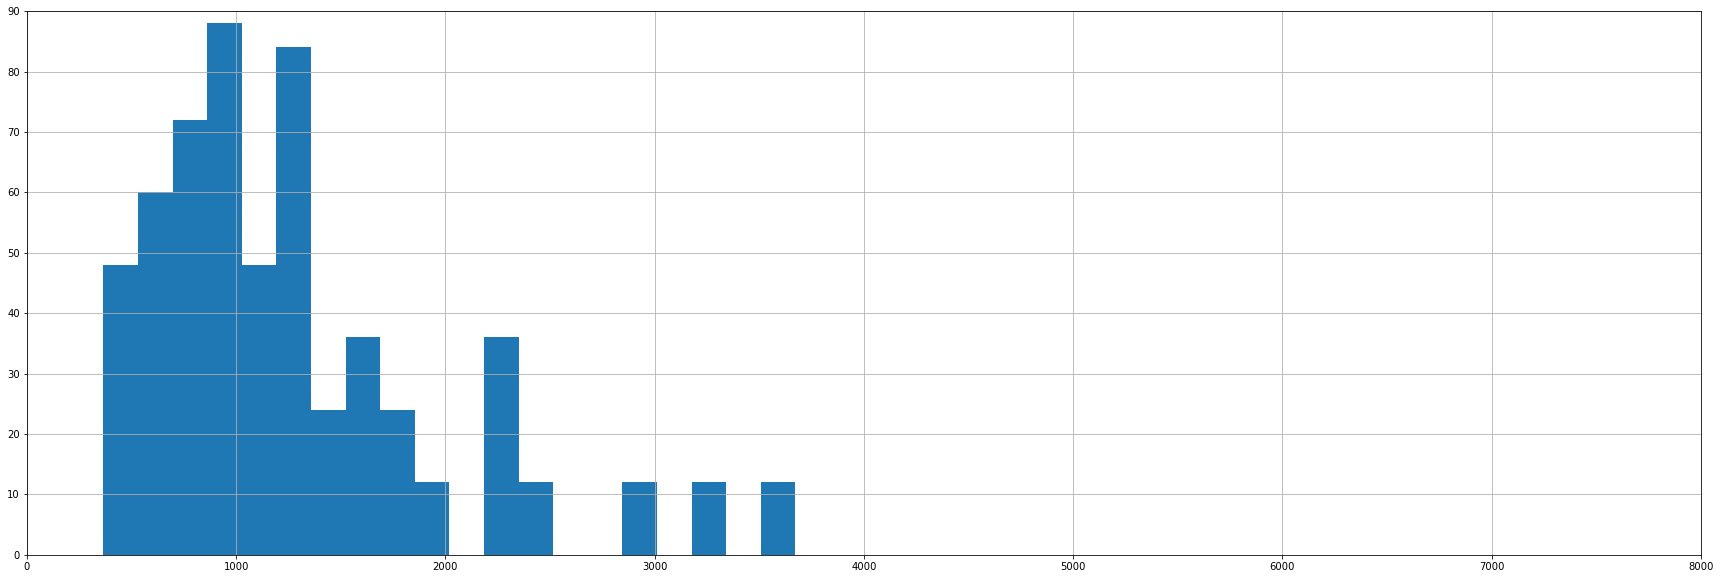

In [43]:
# SXF distribution of distances of connections
fig, ax = plt.subplots(figsize=(30,10));
routes_b_2018.loc[routes_b_2018["fr_airport"] == "EDDB"]["distance"].hist(bins=20, ax=ax);
plt.ylim(0,90);
plt.xlim(0,8000);

In [44]:
routes_b_2018.loc[routes_b_2018["fr_airport"] == "EDDB"].describe()

,flight_d,seat_d,passenger_d,distance
count,580.000000,580.000000,580.000000,580.000000
mean,58.396552,10020.772414,8626.641379,1293.535896
std,32.531658,5588.466127,4739.594432,714.972264
min,4.000000,28.000000,7.000000,364.838246
25%,32.000000,5837.000000,5036.250000,828.065624
50%,50.000000,8340.500000,7525.500000,1076.858393
75%,70.250000,12015.000000,10664.750000,1601.643402
max,160.000000,29471.000000,25291.000000,3672.588688


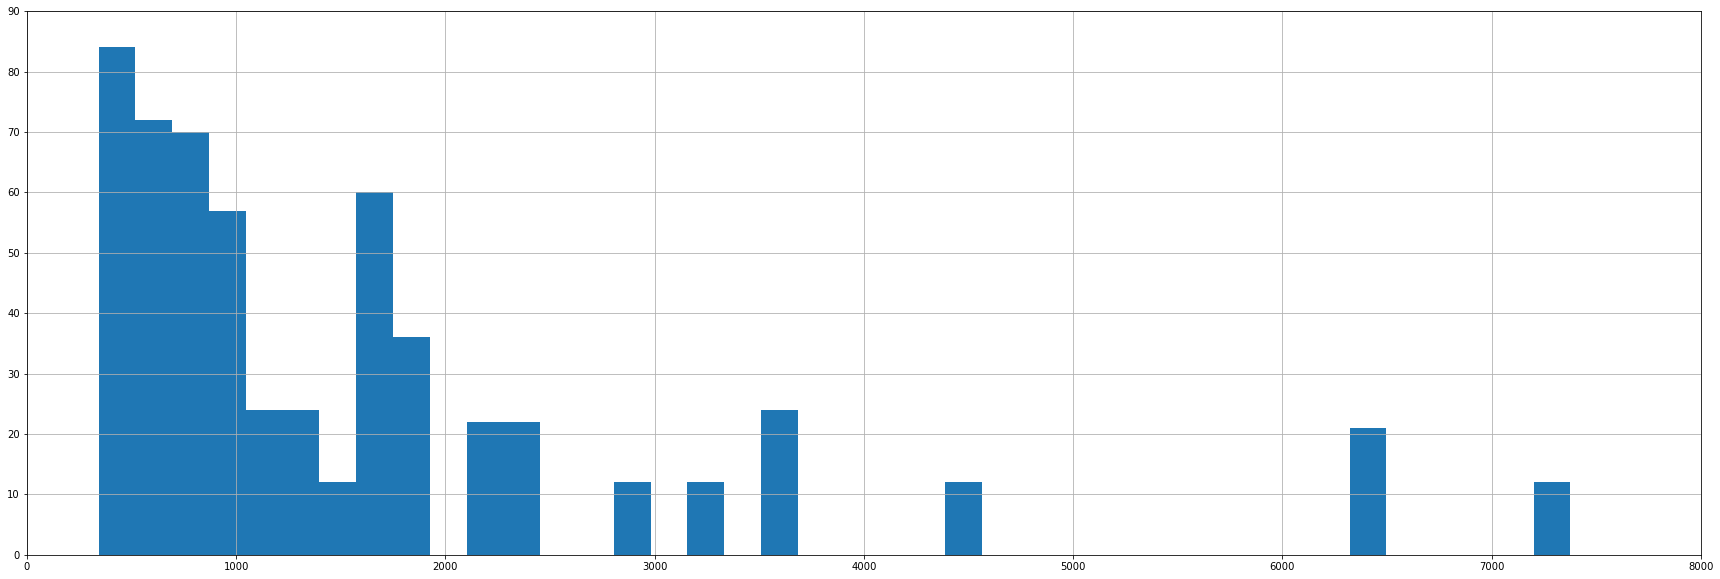

In [45]:
# Tegel distribution of distance of the conections
fig, ax = plt.subplots(figsize=(30,10));
routes_b_2018.loc[routes_b_2018["fr_airport"] == "EDDT"]["distance"].hist(bins=40, ax=ax);
plt.ylim(0,90);
plt.xlim(0,8000);

In [46]:
routes_b_2018.loc[routes_b_2018["fr_airport"] == "EDDT"].describe()

,flight_d,seat_d,passenger_d,distance
count,576.000000,576.000000,576.000000,576.000000
mean,138.178819,22876.015625,17116.232639,1684.857129
std,171.066153,28910.906407,21190.016007,1567.519847
min,1.000000,8.000000,1.000000,342.894486
25%,31.000000,5586.000000,4341.500000,654.052562
50%,64.000000,9405.500000,7377.500000,1121.329637
75%,142.000000,26176.250000,20282.500000,1914.292295
max,824.000000,148625.000000,113748.000000,7376.329350


For year 2018
- The amount of routes between SXF and TXL are very close (580 vs 576)
- However the mean of flights per connection is more than double in TXL (therefore also seats available and passengers)
- The median distance of both airports are quite similar (1076 vs 1121)
- However, the std is double in TXL: strong concentration under 1000km and and some cases over 4000km
- SXF concentrates its flights 50% of its flights 1000 to 3500km

### Now check of utilisation and avg plane size

In [47]:
routes_b_2018

,route,fr_country,fr_airport,to_country,to_airport,month,flight_d,seat_d,passenger_d,flight,distance
1088,DE_EDDB_AT_LOWW,DE,EDDB,AT,LOWW,2018-12-01,33.0,4512.0,2904.0,DE_EDDB_AT_LOWW,522.191804
1089,DE_EDDB_BE_EBBR,DE,EDDB,BE,EBBR,2018-12-01,39.0,7371.0,6790.0,DE_EDDB_BE_EBBR,646.455762
1090,DE_EDDB_BG_LBSF,DE,EDDB,BG,LBSF,2018-12-01,34.0,6060.0,5701.0,DE_EDDB_BG_LBSF,1306.358290
1091,DE_EDDB_CH_LSGG,DE,EDDB,CH,LSGG,2018-12-01,62.0,9557.0,7980.0,DE_EDDB_CH_LSGG,869.238264
1092,DE_EDDB_CH_LSZH,DE,EDDB,CH,LSZH,2018-12-01,5.0,54.0,14.0,DE_EDDB_CH_LSZH,652.679807
...,...,...,...,...,...,...,...,...,...,...,...
2239,DE_EDDT_UA_UKBB,DE,EDDT,UA,UKBB,2018-01-01,32.0,5874.0,2565.0,DE_EDDT_UA_UKBB,1245.145555
2240,DE_EDDT_UK_EGLC,DE,EDDT,UK,EGLC,2018-01-01,64.0,5942.0,4128.0,DE_EDDT_UK_EGLC,914.343880
2241,DE_EDDT_UK_EGLL,DE,EDDT,UK,EGLL,2018-01-01,274.0,42576.0,27121.0,DE_EDDT_UK_EGLL,950.244024
2242,DE_EDDT_US_KEWR,DE,EDDT,US,KEWR,2018-01-01,18.0,3821.0,2810.0,DE_EDDT_US_KEWR,6404.820906


In [48]:
# add avg plane size and utilisation
routes_b_2018 = (routes_b_2018
                 .assign(avg_plane = (routes_b_2018['seat_d'] / routes_b_2018['flight_d'])))
routes_b_2018 = (routes_b_2018
                 .assign(utilisation = (routes_b_2018['passenger_d'] / routes_b_2018['seat_d'])))


In [49]:
# drop unnecessary repeated column flight
routes_b_2018 = routes_b_2018.drop(columns = "flight")

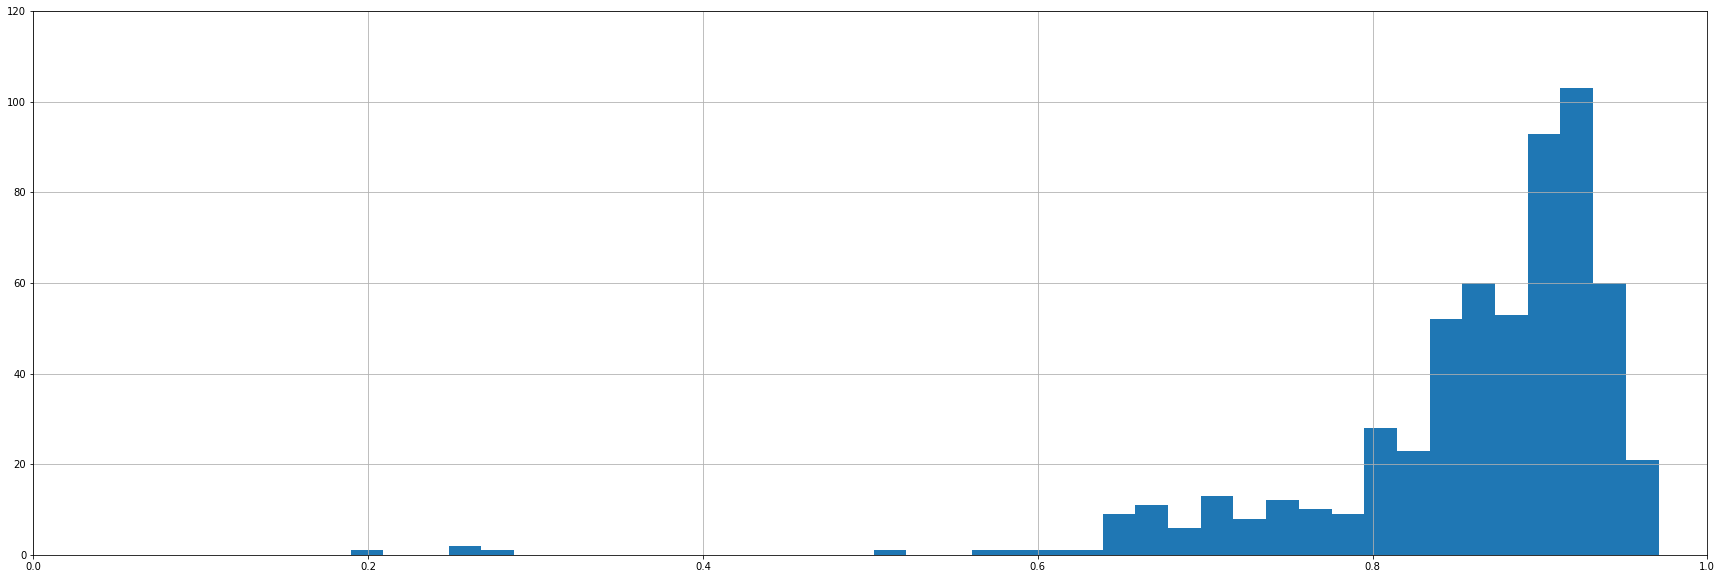

In [50]:
# SXF
fig, ax = plt.subplots(figsize=(30,10));
routes_b_2018.loc[routes_b_2018["fr_airport"] == "EDDB"]["utilisation"].hist(bins=40, ax=ax);
plt.ylim(0,120);
plt.xlim(0,1);

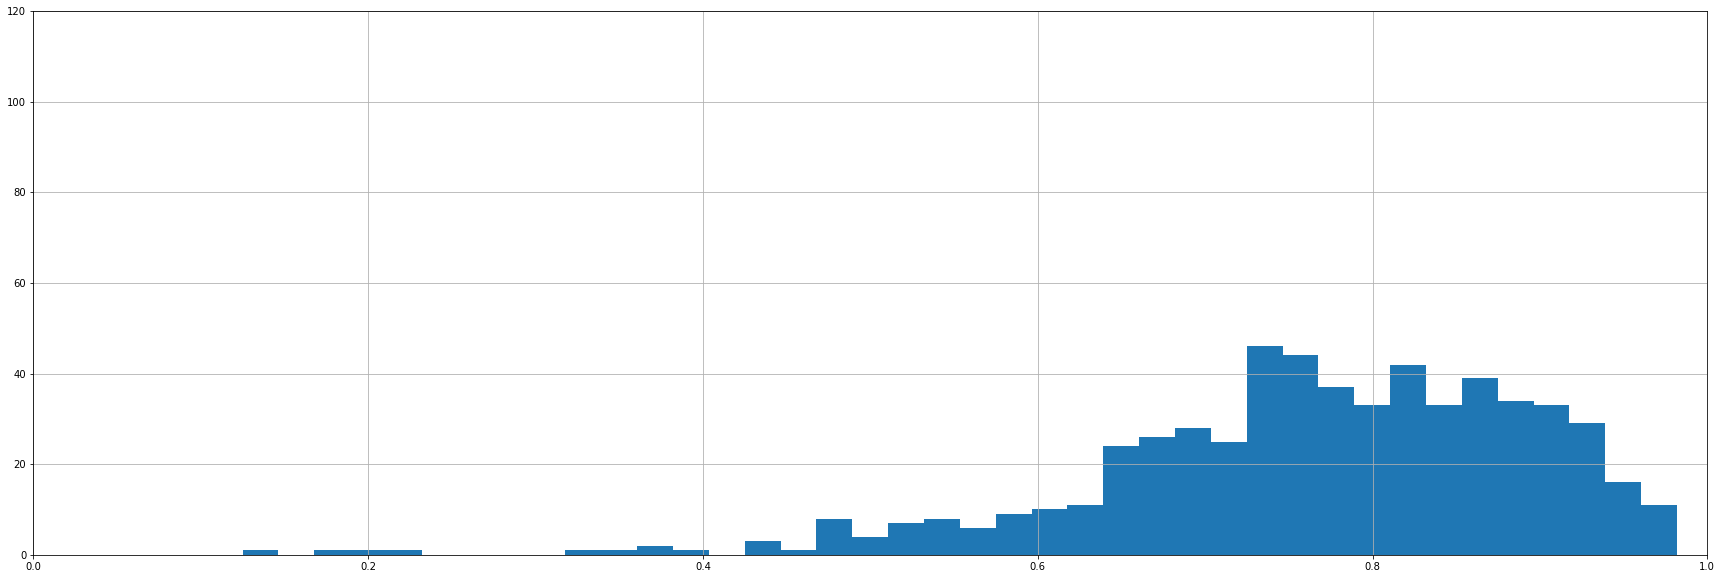

In [51]:
# TXL
fig, ax = plt.subplots(figsize=(30,10));
routes_b_2018.loc[routes_b_2018["fr_airport"] == "EDDT"]["utilisation"].hist(bins=40, ax=ax);
plt.ylim(0,120);
plt.xlim(0,1);

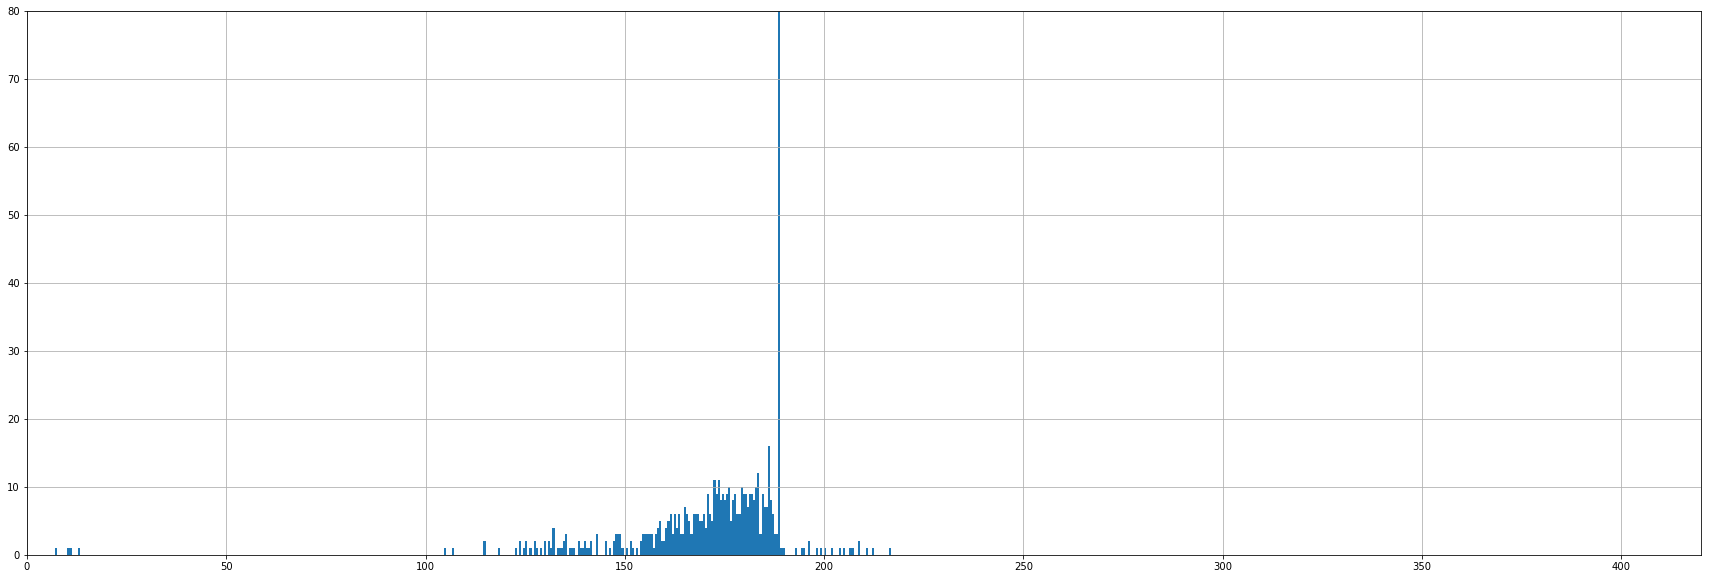

In [52]:
# SXF
fig, ax = plt.subplots(figsize=(30,10));
routes_b_2018.loc[routes_b_2018["fr_airport"] == "EDDB"]["avg_plane"].hist(bins=400, ax=ax);
plt.ylim(0,80);
plt.xlim(0,420);

# it seems there is a size of plane very popular in SXF

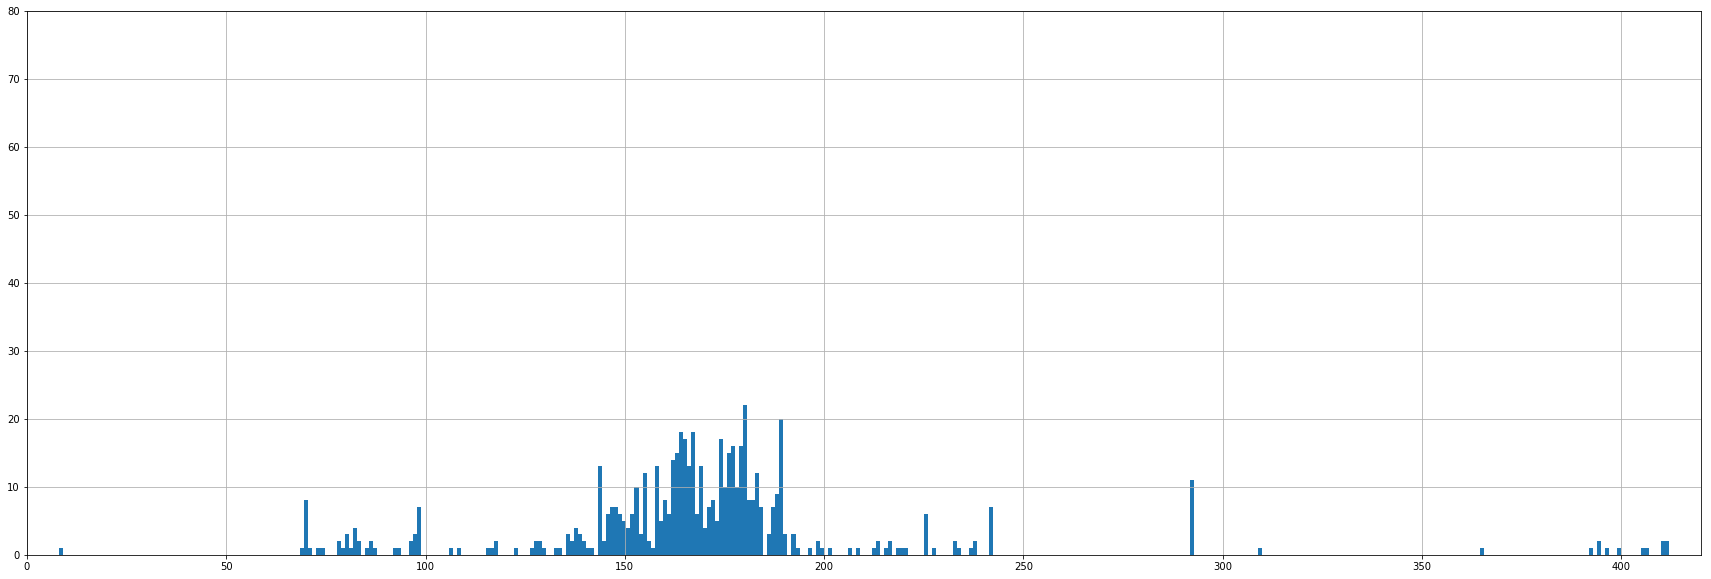

In [53]:
# TXL
fig, ax = plt.subplots(figsize=(30,10));
routes_b_2018.loc[routes_b_2018["fr_airport"] == "EDDT"]["avg_plane"].hist(bins=400, ax=ax);
plt.ylim(0,80);
plt.xlim(0,420);
# in TXL there is more variaty of plane sizes

## Generalisation:

### - SXF crowded planes (always the same size) to somewhere in Europe, very likely sunnier than Berlin
### - TXL half empty planes of all sizes to somewhere far far away or very close (speculative to jump far far away)

## Try scatter plot

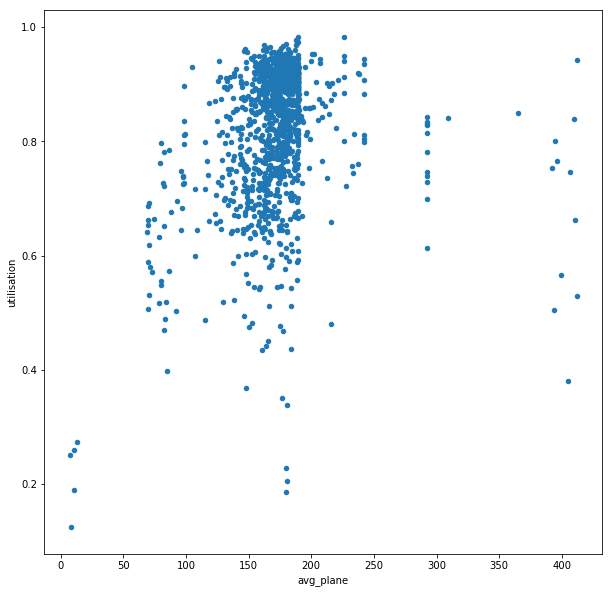

In [54]:
# scatter plot between avg size of the planes and utilisation in the routes
fig, ax = plt.subplots(figsize=(10,10));
ax = routes_b_2018.plot.scatter(x="avg_plane", y="utilisation", ax=ax);

### Not clear story / visualisation here